In [1]:
%load_ext autoreload
#To update the imported files

In [42]:
%autoreload
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, '../')
from constants import *
from utilities_xgb import *
from utilities import *

In [5]:
hyperparameters = {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}

# Dataset A

In [43]:
selected_features_a = selected_features.copy()
#selected_features_a.remove("direct_rad:W")
hyperparameters_a = hyperparameters
wanted_months_a = wanted_months

In [ ]:
df = subset_months(X_observed_a,wanted_months_a)

In [ ]:
df_2 = df[selected_features_a]

In [44]:
X_train_a_prep = prepare_X(X_observed_a, X_estimated_a, selected_features_a, wanted_months_a)
X_train_a, y_train_a = resize_training_data(X_train_a_prep, y_a)
X_test_a_prep = prepare_testdata_rf_a(X_test_a, selected_features_a)

In [ ]:
xgb_a = XGB_model(hyperparameters_a, X_train_a, X_test_a_prep, y_train_a)

In [ ]:
xgb_a_cross_val_predictions,xgb_a_cross_val_actuals, xgb_a_cross_val_mae_mean = xgb_a.cross_val_stack(X_train_a, y_train_a)

In [ ]:
#xgb_a.cross_validate(X_train_a, y_train_a)

In [ ]:
xgb_a.fit()
xgb_a.pred()
xgb_a_test_pred = xgb_a.prediction
#xgb_a.feature_importence_plot()

276.53471563443065


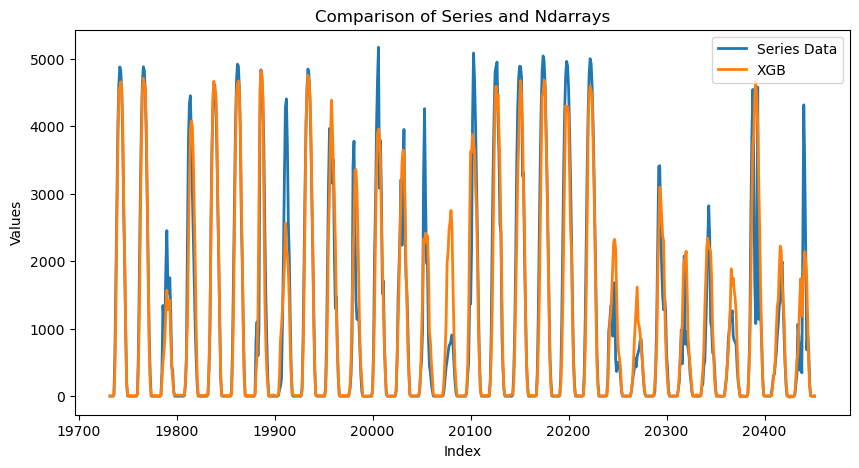

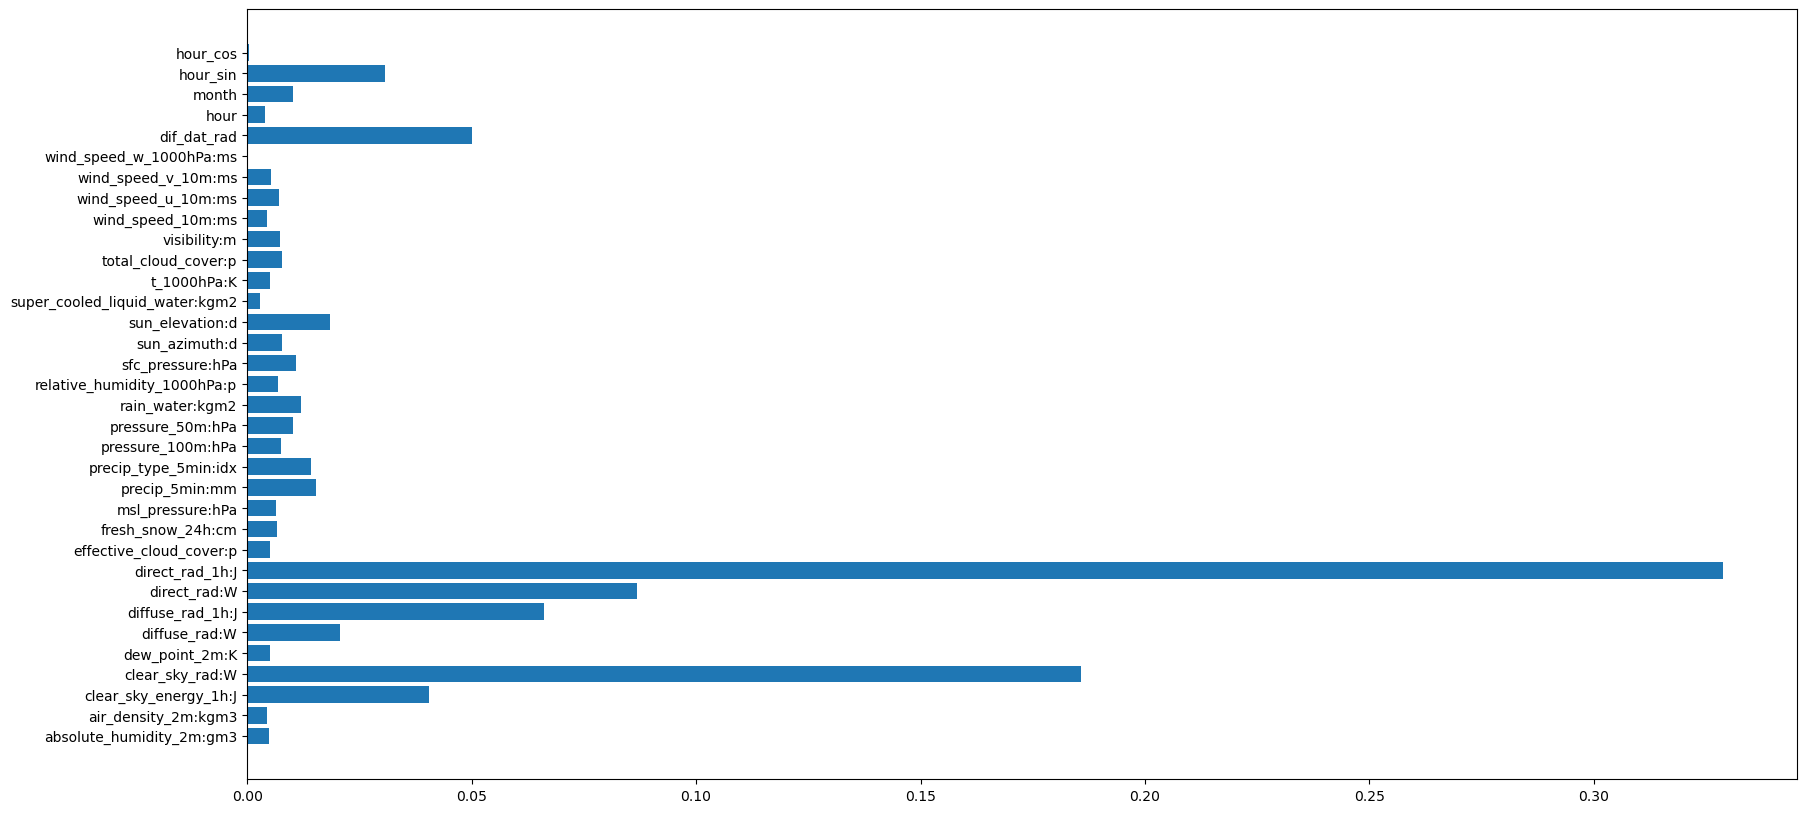

In [46]:
X_valid = X_train_a[-24*30:]
X_train_a_reduced = X_train_a[:-24*30]
y_train_a_reduced = y_train_a[:-24*30]
y_valid= y_train_a[-24*30:]

xgb_base = XGB_model(hyperparameters_a, X_train_a_reduced, X_test_a_prep, y_train_a_reduced)
xgb_base.fit()
xgb_base.pred(X_valid)
mae = mean_absolute_error(y_valid["pv_measurement"], xgb_base.pred_estimated)
print(mae)
import matplotlib.pyplot as plt

# Again, assuming you have the following:
# series_data - This is your pandas Series
# ndarray1 - Your first NumPy array
# ndarray2 - Your second NumPy array

# Now plot all three with matplotlib
plt.figure(figsize=(10,5))

plt.plot(y_valid.index, y_valid["pv_measurement"], label='Series Data', linewidth=2)
plt.plot(y_valid.index, xgb_base.pred_estimated, label='XGB', linewidth=2)  # Assumes same index as series_data

plt.legend()
plt.title('Comparison of Series and Ndarrays')
plt.xlabel('Index')
plt.ylabel('Values')
plt.show()
xgb_base.feature_importence_plot()

In [57]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assuming `df` is a pandas DataFrame containing your data
# Add a constant for the intercept term
X = add_constant(X_train_a)

# Create a DataFrame that will hold VIF scores
VIF_df = pd.DataFrame()
VIF_df["variable"] = X.columns

# Calculate VIF for each explanatory variable
VIF_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(VIF_df)

                          variable            VIF
0                            const  427369.702461
1         absolute_humidity_2m:gm3      29.212370
2              air_density_2m:kgm3     367.850257
3            clear_sky_energy_1h:J    4198.349688
4                  clear_sky_rad:W    4159.029239
5                   dew_point_2m:K     158.604721
6                    diffuse_rad:W     339.104194
7                 diffuse_rad_1h:J     365.172494
8                     direct_rad:W     288.744168
9                  direct_rad_1h:J     300.037753
10         effective_cloud_cover:p      13.653365
11               fresh_snow_24h:cm       1.158036
12                msl_pressure:hPa   44827.395335
13                  precip_5min:mm       1.622963
14            precip_type_5min:idx       1.645426
15               pressure_100m:hPa  323036.558164
16                pressure_50m:hPa  379504.034647
17                 rain_water:kgm2       1.586243
18     relative_humidity_1000hPa:p      17.957650


                               SARIMAX Results                                
Dep. Variable:         pv_measurement   No. Observations:                34085
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -256811.003
Date:                Mon, 06 Nov 2023   AIC                         513628.006
Time:                        10:32:05   BIC                         513653.316
Sample:                             0   HQIC                        513636.078
                              - 34085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        630.5947     55.681     11.325      0.000     521.461     739.728
ar.L1          0.9215      0.002    428.543      0.000       0.917       0.926
sigma2       2.05e+05    826.232    248.159      0.0

<AxesSubplot:title={'center':'Density'}, ylabel='Density'>

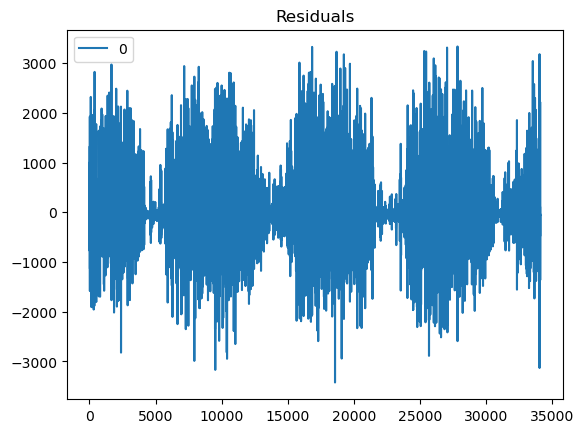

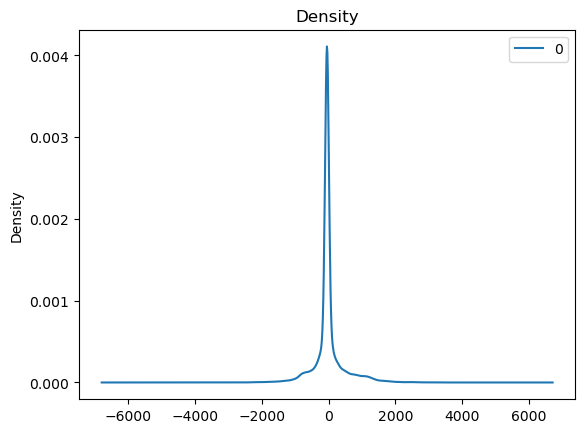

In [55]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Assume y_data is your time series data.
# Fit an ARIMA model
model = ARIMA(y_a["pv_measurement"], order=(1,0,0)) # AR(1) model without differencing
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title='Residuals')
residuals.plot(kind='kde', title='Density')


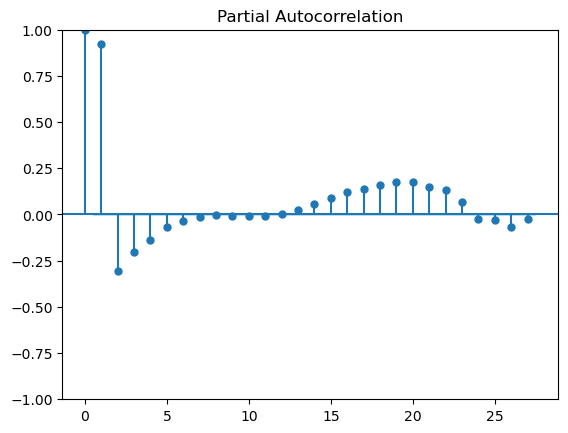

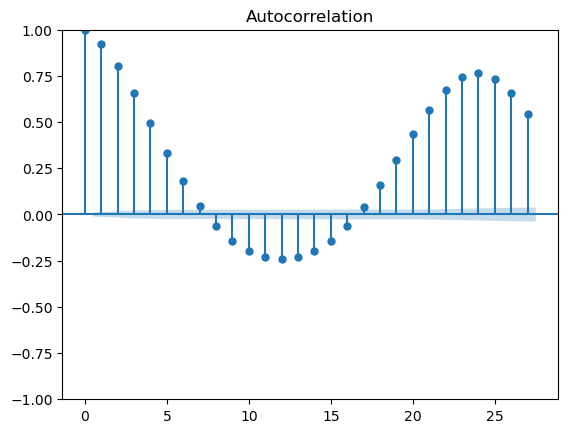

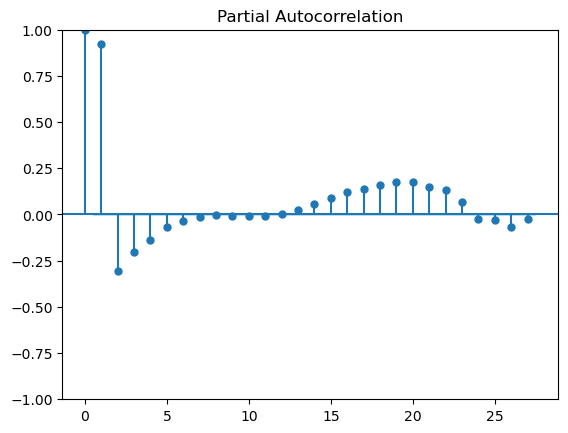

In [52]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
# 'your_time_series' should be a Pandas Series or a NumPy array.
# Let's say 'y_data' is your time series data.
lag_acf = acf(y_a["pv_measurement"], nlags=27)
plot_acf(y_a["pv_measurement"], lags=27)

from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
# 'your_time_series' should be a Pandas Series or a NumPy array.
# Let's say 'y_data' is your time series data.
lag_pacf = pacf(y_a["pv_measurement"], nlags=27)
plot_pacf(y_a["pv_measurement"], lags=27)

In [47]:
residual = y_valid["pv_measurement"] - xgb_base.pred_estimated
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residual)
print(dw_stat)

0.6301887396247539


# Dataset B

In [ ]:
selected_features_b = selected_features
hyperparameters_b = hyperparameters
wanted_months_b = wanted_months

In [ ]:
X_train_b_prep = prepare_X(X_observed_b, X_estimated_b, selected_features_b, wanted_months_b)
X_train_b, y_train_b = resize_training_data(X_train_b_prep, y_b)
X_test_b_prep = prepare_testdata_rf_a(X_test_b, selected_features_b)

In [ ]:
xgb_b = XGB_model(hyperparameters_b, X_train_b, X_test_b_prep, y_train_b)

In [ ]:
xgb_b_cross_val_predictions,xgb_b_cross_val_actuals, xgb_b_cross_val_mae_mean = xgb_b.cross_val_stack(X_train_b, y_train_b)

In [ ]:
#xgb_b.cross_validate(X_train_b, y_train_b)

In [ ]:
xgb_b.fit()
xgb_b.pred()
xgb_b_test_pred = xgb_b.prediction
#xgb_b.feature_importence_plot()

# Dataset C

In [23]:
selected_features_c = selected_features.copy()
hyperparameters_c = hyperparameters
wanted_months_c = wanted_months

In [24]:
X_train_c_prep = prepare_X(X_observed_c, X_estimated_c, selected_features_c, wanted_months_c)
X_train_c, y_train_c = resize_training_data(X_train_c_prep, y_c)
X_test_c_prep = prepare_testdata_rf_a(X_test_c, selected_features_c)

In [ ]:
y_train_c[-24*30:]

In [ ]:
xgb_c = XGB_model(hyperparameters_c, X_train_c, X_test_c_prep, y_train_c)

In [ ]:
xgb_c_cross_val_predictions,xgb_c_cross_val_actuals, xgb_c_cross_val_mae_mean = xgb_c.cross_val_stack(X_train_c, y_train_c)

In [ ]:
#xgb_c.cross_validate(X_train_c, y_train_c)

47.87152197030352


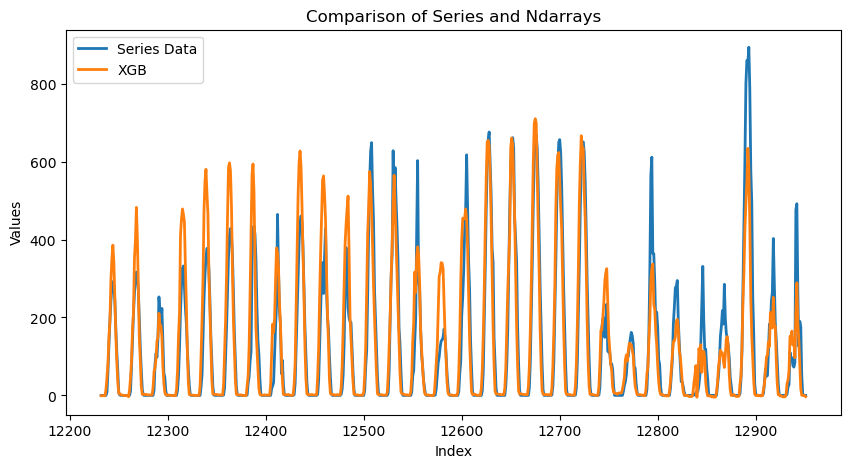

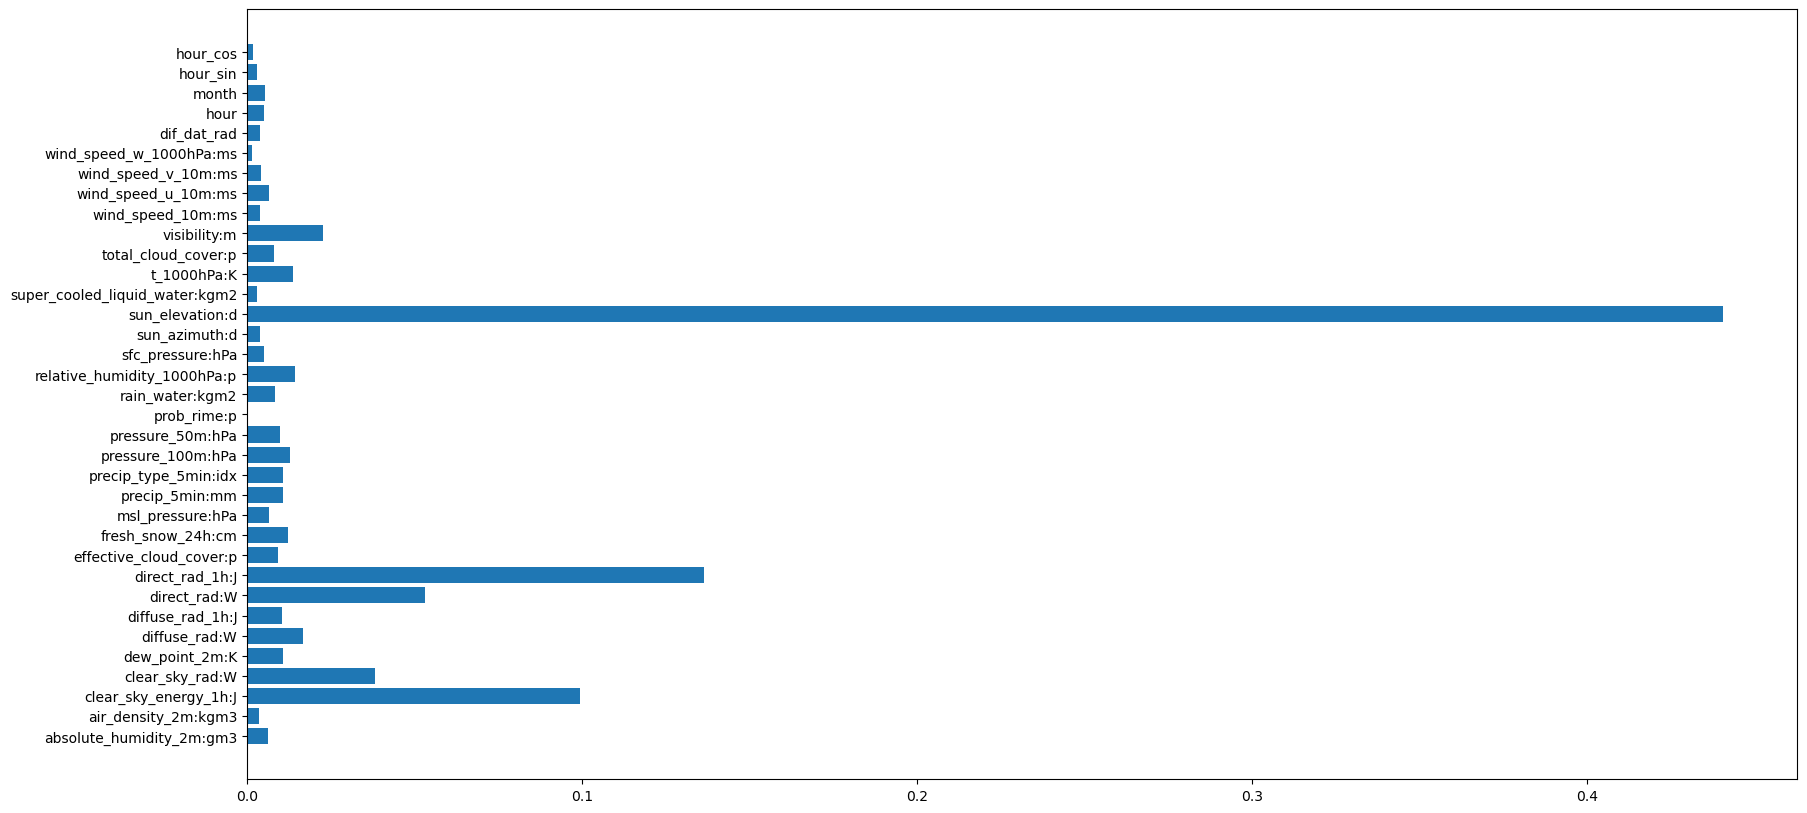

In [25]:
"""X_validd = X_train_c[-24*30:]
X_train_c_reduced = X_train_c[:-24*30]
y_train_c_reduced = y_train_c[:-24*30]
y_validd = y_train_c[-24*30:]

xgb_base_c = XGB_model(hyperparameters_c, X_train_c_reduced, X_test_c_prep, y_train_c_reduced)
xgb_base_c.fit()
xgb_base_c.pred(X_validd)
mae = mean_absolute_error(y_validd["pv_measurement"], xgb_base_c.pred_estimated)
print(mae)
import matplotlib.pyplot as plt

# Again, assuming you have the following:
# series_data - This is your pandas Series
# ndarray1 - Your first NumPy array
# ndarray2 - Your second NumPy array

# Now plot all three with matplotlib
plt.figure(figsize=(10,5))

plt.plot(y_validd.index, y_validd["pv_measurement"], label='Series Data', linewidth=2)
plt.plot(y_validd.index, xgb_base_c.pred_estimated, label='XGB', linewidth=2)  # Assumes same index as series_data

plt.legend()
plt.title('Comparison of Series and Ndarrays')
plt.xlabel('Index')
plt.ylabel('Values')
plt.show()
xgb_base_c.feature_importence_plot()"""

In [ ]:
xgb_c.fit()
xgb_c.pred()
xgb_c_test_pred = xgb_c.prediction
xgb_c.feature_importence_plot()